### Performance comparison of SLS and LQR controllers with bound constraints on the control and on the state 

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from copy import deepcopy
from time import time
from isls import SLS
from isls.utils import get_double_integrator_AB
from isls.projections import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)
plt.rcParams["figure.figsize"] = (4,3)
real_min = np.finfo(float).tiny

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Problem setup

In [37]:
x_dim = 1
u_dim = 1
T = 1.
horizon = 100
nb_deriv = 2
N = horizon
dt = T/horizon
print("dt:", dt)
d = x_dim*nb_deriv
A, B = get_double_integrator_AB(x_dim, nb_deriv=nb_deriv, dt=dt)

dt: 0.01


In [38]:
%%time
sls = SLS(d, u_dim, horizon)
sls.AB = [A,B]

Wall time: 0 ns


Define the task:

In [40]:
u_std=1e-2
x_final_target = np.array([1., 0.])
viaQ_final = np.diag([1e0, 1e6])

free_state = np.zeros(d)
viaQ_free = np.diag([0]*d)

zs = np.stack([free_state,  x_final_target])
Qs = np.stack([viaQ_free,  viaQ_final])

seq = np.zeros(N, dtype=np.int32)
seq[N-1] = 1

In [41]:
sls.set_cost_variables(zs, Qs, seq, u_std)

In [42]:
%%time
sls.solve()
K_init, k_init = sls.controller()

Wall time: 46.9 ms


In [43]:
%%time
K_wo_const, k_wo_const = sls.solve_DP()

Wall time: 0 ns


MAX control:  0.45334726272712483
Last position:  0.07480244871740602
Last velocity:  4.5797232528684007e-07


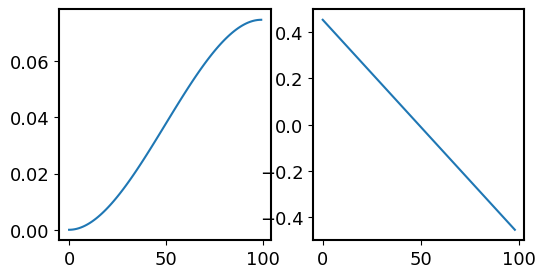

In [44]:
x0 = np.zeros(d)
fig,ax = plt.subplots(ncols=2, figsize=(6,3))
ax[1].plot(sls.u_opt(x0).flatten())
ax[0].plot(sls.x_opt(x0)[:,0])

print("MAX control: ", np.max(sls.du))
print("Last position: ", sls.x_opt(x0)[-1,0])
print("Last velocity: ", sls.x_opt(x0)[-1,1])

## ADMM Optimization with state bounds on the given timestep

### Define constraints

In [45]:
nb_proj = 1
lower_x_final = 0.5
upper_x_final = 1.0
lower_dx = -1.
upper_dx = 0.7
def make_function(i):
    def f(y):
        y[-2] = project_bound(y[-2], lower_x_final, upper_x_final)
        y[1::d] = project_bound(y[1::d], lower_dx, upper_dx)
        return y
    return f
list_of_proj_x = []
for i in range(nb_proj):
    list_of_proj_x += [make_function(i)]
    
lower_u = -3.5
upper_u = 3.5
nb_proj = 1
def make_function(i):
    def f(y):
        return project_bound(y, lower_u, upper_u)
    return f

list_of_proj_u = []
for i in range(nb_proj):
    list_of_proj_u += [make_function(i)]
    

### Batch LQT - ADMM

Converged at iteration  29 !
Residual is  3.64e-06 4.38e-05
Constrained cost is 3.41e+00
Unconstrained cost is 9.25e-01
Wall time: 62.4 ms


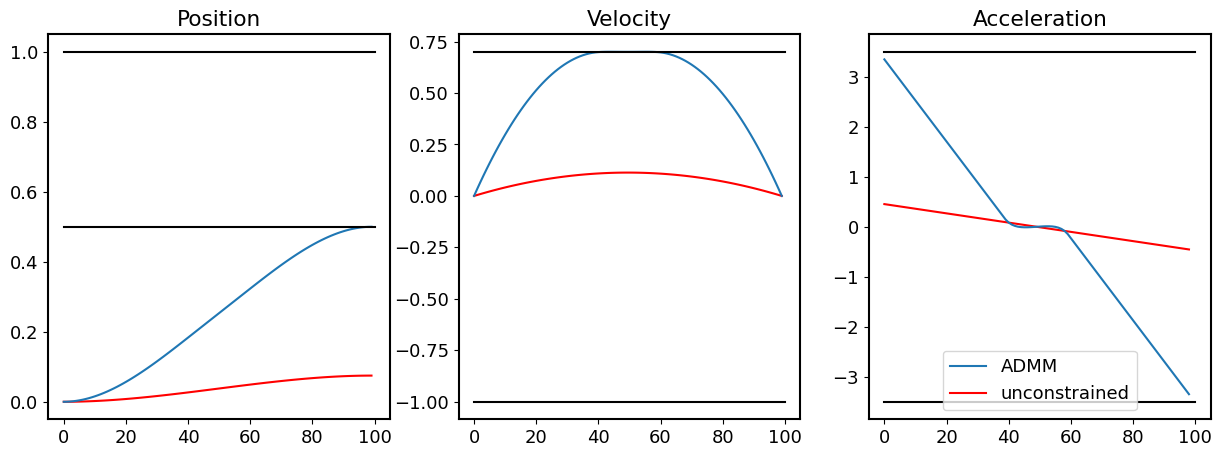

In [46]:
%%time
    
x0 = np.zeros(d)
# Final timestep position and all timestep velocities are constrained.
rho_x = np.zeros((N, d, d))
rho_x[-1, 0, 0] = 1e2 # Final timestep position
rho_x[:, 1, 1] = 1e0 # all timestep velocities

# rho_x = 0.
rho_u = 1e-2
rho_x = scipy.linalg.block_diag(*rho_x)

u_optimal, log = sls.ADMM_LQT_Batch(np.zeros(d), list_of_proj_x=list_of_proj_x,list_of_proj_u=list_of_proj_u, max_iter=50000, 
                                      rho_x=rho_x, rho_u=rho_u, threshold=1e-4, warm_start=0, init_guess=None, verbose=False, log=True)
fig,ax = plt.subplots(ncols=3, figsize=(15,5*x_dim))
x_optimal = sls.C[:,:d]@x0 + sls.D@u_optimal
ax[0].plot(x_optimal.reshape(N,-1)[:,0], label="ADMM")
ax[0].plot(sls.x_opt(x0)[:,0], "r", label="unconstrained", zorder=1)
ax[0].plot([0,N],[lower_x_final]*2, "k")
ax[0].plot([0,N],[upper_x_final]*2, "k")

ax[1].plot(x_optimal.reshape(N,-1)[:,1])
ax[1].plot(sls.x_opt(x0)[:,1], "r", zorder=1)
ax[1].plot([0,N],[lower_dx]*2, "k")
ax[1].plot([0,N],[upper_dx]*2, "k")

ax[2].plot(u_optimal.reshape(N,-1)[:-1], label="ADMM")
ax[2].plot(sls.u_opt(x0).flatten(), "r", label="unconstrained", zorder=1)
ax[2].plot([0,N*u_dim],[lower_u]*2, "k")
ax[2].plot([0,N*u_dim],[upper_u]*2, "k")
titles = ["Position", "Velocity", "Acceleration"]
for i in range(3):
    ax[i].set_title(titles[i])

plt.legend()
print("Constrained cost is", "{:.2e}".format(sls.cost(x_optimal, u_optimal)))
print("Unconstrained cost is", "{:.2e}".format(sls.cost(sls.dx, sls.du)))

Converged at iteration  29 !
Residual is  3.64e-06 4.38e-05
Constrained cost is 3.41e+00
Unconstrained cost is 9.25e-01
Wall time: 84.7 ms


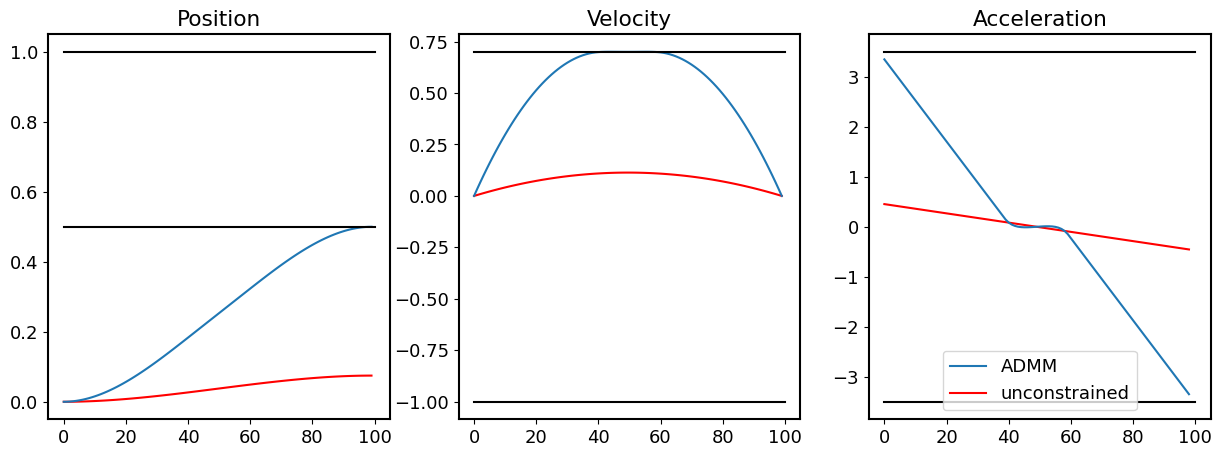

In [47]:
%%time
# Final timestep position and all timestep velocities are constrained.
rho_x = np.zeros((N, d, d))
rho_x[-1, 0, 0] = 1e2 # Final timestep position
rho_x[:, 1, 1] = 1e0 # all timestep velocities

# rho_x = 0.
rho_u = 1e-2
x0 = np.zeros(d)
u_optimal, log_DP, K_optimal, k_optimal = sls.ADMM_LQT_DP(np.zeros(d), list_of_proj_x=list_of_proj_x, list_of_proj_u=list_of_proj_u,
                                                          max_iter=5000,  rho_x=rho_x, rho_u=rho_u, threshold=1e-4, verbose=False, log=True)
fig,ax = plt.subplots(ncols=3, figsize=(15,5*x_dim))
x_optimal = sls.C[:,:d]@x0 + sls.D@u_optimal
ax[0].plot(x_optimal.reshape(N,-1)[:,0], label="ADMM")
ax[0].plot(sls.x_opt(x0)[:,0], "r", label="unconstrained", zorder=1)
ax[0].plot([0,N],[lower_x_final]*2, "k")
ax[0].plot([0,N],[upper_x_final]*2, "k")

ax[1].plot(x_optimal.reshape(N,-1)[:,1])
ax[1].plot(sls.x_opt(x0)[:,1], "r", zorder=1)
ax[1].plot([0,N],[lower_dx]*2, "k")
ax[1].plot([0,N],[upper_dx]*2, "k")

ax[2].plot(u_optimal.reshape(N,-1)[:-1], label="ADMM")
ax[2].plot(sls.u_opt(x0).flatten(), "r", label="unconstrained", zorder=1)
ax[2].plot([0,N*u_dim],[lower_u]*2, "k")
ax[2].plot([0,N*u_dim],[upper_u]*2, "k")
titles = ["Position", "Velocity", "Acceleration"]
for i in range(3):
    ax[i].set_title(titles[i])

plt.legend()
print("Constrained cost is", "{:.2e}".format(sls.cost(x_optimal, u_optimal)))
print("Unconstrained cost is", "{:.2e}".format(sls.cost(sls.dx, sls.du)))

In [48]:
from scipy.stats import norm

# For robust constraints only for x0's position, z has dim 1+x_dim
x0_pos = np.zeros(x_dim)
mu = np.zeros(x_dim + 1) # [1, x0]
mu[0] = 1. 
mu[1:] = x0_pos

var_x0 = 0.01
sigma = np.zeros(x_dim + 1)
sigma[0] = 0. # first term is deterministic and equal to one.
sigma[1:] = var_x0 # variance for the x0
psi_inv = norm.ppf(0.96)
# psi_inv = norm.ppf(0.5)+1e-100 # should be the same as expected
 
Au = np.diag(np.sqrt(sigma))
bu = np.zeros(Au.shape[0])
cu = -mu/psi_inv
du = upper_u/psi_inv

Al = Au
bl = bu
cl = mu/psi_inv
dl = -lower_u/psi_inv

As = [Au, Al]
bs = [bu, bl]
cs = [cu, cl]
ds = [du, dl]


nb_proj = 2 # nb of projections needed for each row of psi_u
list_of_proj_u = []
def make_function(i):
    def f(y):
        return project_soc(y, As[i], bs[i], cs[i], ds[i])
    return f

for i in range(nb_proj):
    list_of_proj_u += [make_function(i)]
    
    
#####################################################################

# For robust constraints only for x0's position, z has dim 1+x_dim
# lower_x_final = 0.8
# upper_x_final = 1.2
# lower_dx = -1.
# upper_dx = 1.


ds_x_final = [upper_x_final/psi_inv, -lower_x_final/psi_inv]
ds_dx = [upper_dx/psi_inv, -lower_dx/psi_inv]


nb_proj = 2 # nb of projections needed for each row of psi_u
def make_function2(i):
    def f2(y):
        y[-2] = project_soc(y[-2], As[i], bs[i], cs[i], ds_x_final[i])
        # y[1::d] = project_soc(y[1::d], As[i], bs[i], cs[i], ds_dx[i])
        return y
    return f2
list_of_proj_x = []
for i in range(nb_proj):
    list_of_proj_x += [make_function2(i)]

Start iterating..
Converged at iteration  487 !
Residual is  5.10e-29 9.99e-05
Constrained cost is 5.30e+00
Unconstrained cost is 9.25e-01
Wall time: 1.39 s


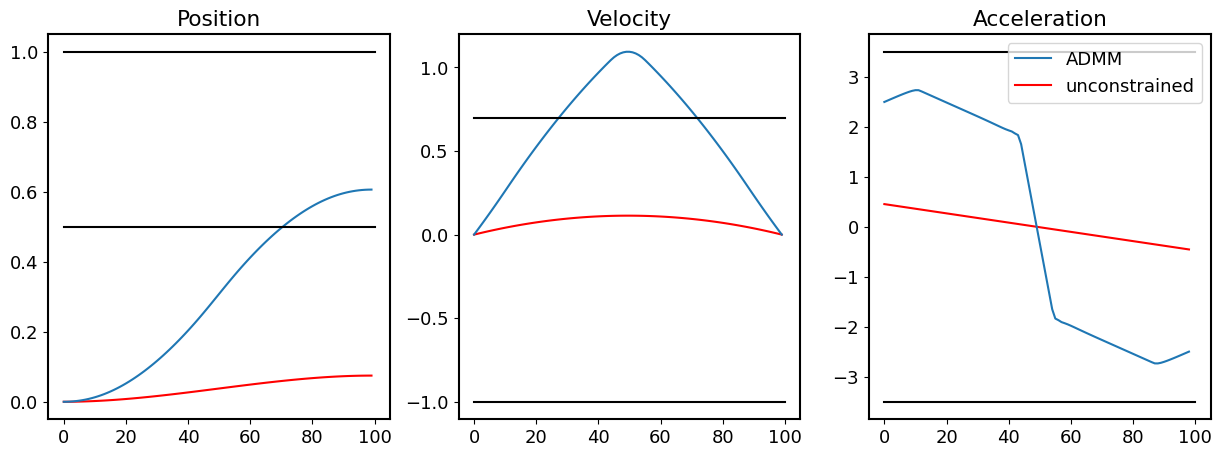

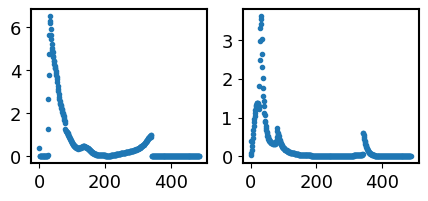

In [49]:
%%time
# Final timestep position and all timestep velocities are constrained.
rho_x = np.zeros((N, d, d))
rho_x[-1, 0, 0] = 1e4 # Final timestep position
rho_x[:, 1, 1] = 0 # all timestep velocities

# rho_x = 0.
rho_u = 1e0
rho_x = scipy.linalg.block_diag(*rho_x)

alpha=0.05
x0 = np.zeros(d)
max_iter = 1000
du, PHI_U,log = sls.ADMM(list_of_proj_u=list_of_proj_u,
                         list_of_proj_x=list_of_proj_x,
                         max_iter=max_iter, rho_x=rho_x, rho_u=rho_u,  alpha=alpha, threshold=1e-4, verbose=False, log=True)
u_optimal = du.copy()
fig,ax = plt.subplots(ncols=3, figsize=(15,5*x_dim))
x_optimal = sls.C[:,:d]@x0 + sls.D@u_optimal
ax[0].plot(x_optimal.reshape(N,-1)[:,0], label="ADMM")
ax[0].plot(sls.x_opt(x0)[:,0], "r", label="unconstrained", zorder=1)
ax[0].plot([0,N],[lower_x_final]*2, "k")
ax[0].plot([0,N],[upper_x_final]*2, "k")

ax[1].plot(x_optimal.reshape(N,-1)[:,1])
ax[1].plot(sls.x_opt(x0)[:,1], "r", zorder=1)
ax[1].plot([0,N],[lower_dx]*2, "k")
ax[1].plot([0,N],[upper_dx]*2, "k")

ax[2].plot(u_optimal.reshape(N,-1)[:-1], label="ADMM")
ax[2].plot(sls.u_opt(x0).flatten(), "r", label="unconstrained", zorder=1)
ax[2].plot([0,N*u_dim],[lower_u]*2, "k")
ax[2].plot([0,N*u_dim],[upper_u]*2, "k")
titles = ["Position", "Velocity", "Acceleration"]
for i in range(3):
    ax[i].set_title(titles[i])

plt.legend()
print("Constrained cost is", "{:.2e}".format(sls.cost(x_optimal, u_optimal)))
print("Unconstrained cost is", "{:.2e}".format(sls.cost(sls.dx, sls.du)))
fig,ax= plt.subplots(ncols=2, figsize=(5,2))
ax[0].plot(np.stack(log)[:,0], ".")
ax[1].plot(np.stack(log)[:,1], ".")

In [50]:
PHI_X = sls.C + sls.D@PHI_U
K_sls = PHI_U @ np.linalg.inv(PHI_X)
k_sls = (np.eye(sls.D.shape[-1]) - K_sls @ sls.D) @ du

In [51]:
scale_noise = 0.0
scale_x0 = np.sqrt(var_x0)
nb_experiments = 5

K_list = [scipy.linalg.block_diag(*K_optimal), K_sls]
k_list = [k_optimal.flatten(), k_sls]

# K_list = [K_init, K_sls]
# k_list = [k_init, k_sls]

x_logs = np.zeros((len(K_list), nb_experiments, N,  x_dim*nb_deriv))
u_logs = np.zeros((len(K_list), nb_experiments, N,  u_dim))
x0_ = np.zeros((nb_experiments, d))
x0_[:, :x_dim] = np.random.normal(loc=np.zeros(x_dim), scale=scale_x0, size=(nb_experiments, x_dim))

cnt = 0
for K,k in zip(K_list, k_list):
    x_vec = np.zeros((nb_experiments, N*d))
    x = deepcopy(x0_)
    for i in range(N):

        x_vec[:, i*d:(i+1)*d] = x
        u = (x_vec@K.T + k)[:, i * u_dim:(i + 1) * u_dim]
        
        x_logs[cnt,:,i] = deepcopy(x)
        u_logs[cnt,:,i] = deepcopy(u)

    
        w = np.random.normal(loc=0, scale=scale_noise, size=(nb_experiments, x_dim*nb_deriv))
        x = sls.forward(x, u) + w

    cnt += 1

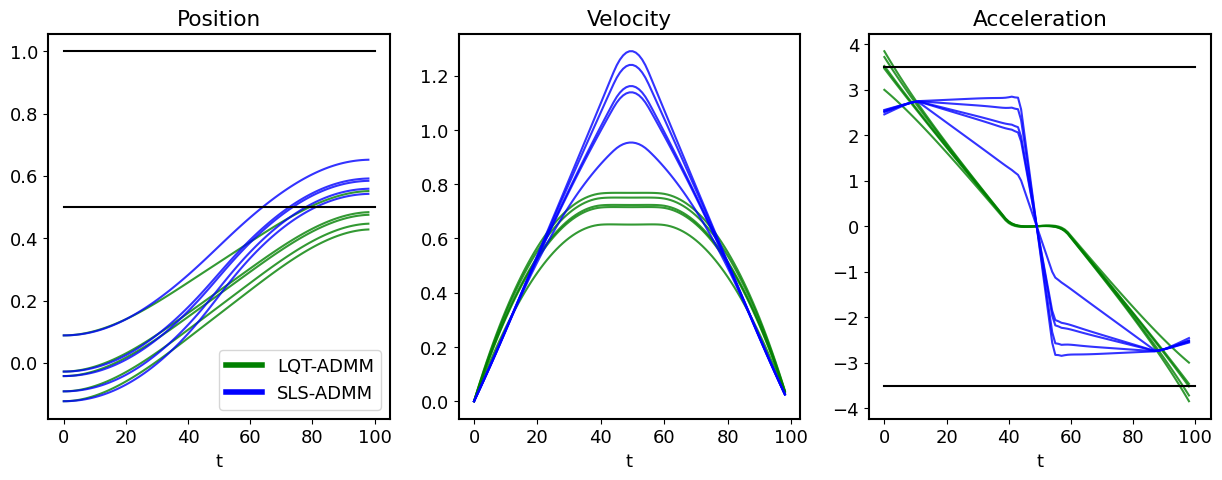

In [52]:
colors = ["g", "b", "orange"]
fig,axes_ = plt.subplots(nrows=x_dim, ncols=3, figsize=(15,5*x_dim))
if x_dim == 1: axes_ = [axes_]

# vias = [via1, via2, via1_, via2_]
# times = [via_time1, via_time2, via_time1_, via_time2_ ]
titles = ["Position", "Velocity", "Acceleration"]
ylabels = np.array([[r"$x$",r"$\dot{x}$",r"$\ddot{x}$"],[r"$y$",r"$\dot{y}$",r"$\ddot{y}$"]])
label =[r"$V_1$", r"$V_2$",r"$VN_1$",r"$VN_2$",]
markers = ["_", "_", "_", "_"]
colors_markers = ["r", "r", "magenta", "magenta"]

changed = True
lw = 15
for dim,axes in enumerate(axes_):

    # axes[0].scatter(horizon-1, x_final_target[0],marker="x", color="k")
    logs = np.concatenate((x_logs, u_logs), -1)
    for i in range(3):
        for cnt,log in enumerate(logs):
            axes[i].plot(log[:, :-1, i*x_dim+dim].T,color=colors[cnt], alpha=0.8)  
        # axes[i].set_ylabel(ylabels[dim,i])
        axes[i].set_xlabel("t")
        axes[i].set_title(titles[i])
# axes[0].set_ylim([-1,1])

axes[0].plot([0,N],[lower_x_final]*2, "k")
axes[0].plot([0,N],[upper_x_final]*2, "k")
# axes[1].plot([0,N],[lower_dx]*2, "k")
# axes[1].plot([0,N],[upper_dx]*2, "k")
axes[2].plot([0,N],[lower_u]*2, "k")
axes[2].plot([0,N],[upper_u]*2, "k")

# from matplotlib.lines import Line2D
from matplotlib.lines import Line2D  
custom_lines = [Line2D([0], [0], color=colors[i], lw=4) for i in range(len(colors))]

axes[0].legend(custom_lines, ['LQT-ADMM', 'SLS-ADMM'])